<a href="https://colab.research.google.com/github/ekvirika/WalmartRecruiting/blob/main/notebooks/model_experiment_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install required packages
!pip install wandb torch torchvision pandas matplotlib seaborn scikit-learn mlflow

# Set up Kaggle API
!pip install kaggle

In [4]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sampleSubmission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip

replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [8]:
!pip install dagshub mlflow --quiet
!pip install optuna
!pip install pmdarima
# !pip install --upgrade numpy scipy statsmodels pmdarima

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import xgboost as xgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models.signature import infer_signature
import warnings
warnings.filterwarnings('ignore')


In [15]:
import mlflow
from dagshub import dagshub_logger
import os

# Set tracking URI manually
mlflow.set_tracking_uri("https://dagshub.com/ekvirika/WalmartRecruiting.mlflow")

# Use your DagsHub credentials
os.environ["MLFLOW_TRACKING_USERNAME"] = "ekvirika"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "0adb1004ddd4221395353efea2d8ead625e26197"

# Optional: set registry if you're using model registry
mlflow.set_registry_uri("https://dagshub.com/ekvirika/WalmartRecruiting.mlflow")

In [16]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [17]:
train["Date"] = pd.to_datetime(train["Date"])
monthly_sales = train.groupby(pd.Grouper(key="Date", freq="ME"))["Weekly_Sales"].sum()

In [15]:
monthly_sales.head()

,Weekly_Sales
Date,
2010-02-28,1.903330e+08
2010-03-31,1.819198e+08
2010-04-30,2.314124e+08
2010-05-31,1.867109e+08
2010-06-30,1.922462e+08


In [18]:
train["Date"] = pd.to_datetime(train["Date"])
weekly_sales = train.groupby(pd.Grouper(key="Date", freq="W"))["Weekly_Sales"].sum()
weekly_sales.head()

,Weekly_Sales
Date,
2010-02-07,49750740.50
2010-02-14,48336677.63
2010-02-21,48276993.78
2010-02-28,43968571.13
2010-03-07,46871470.30


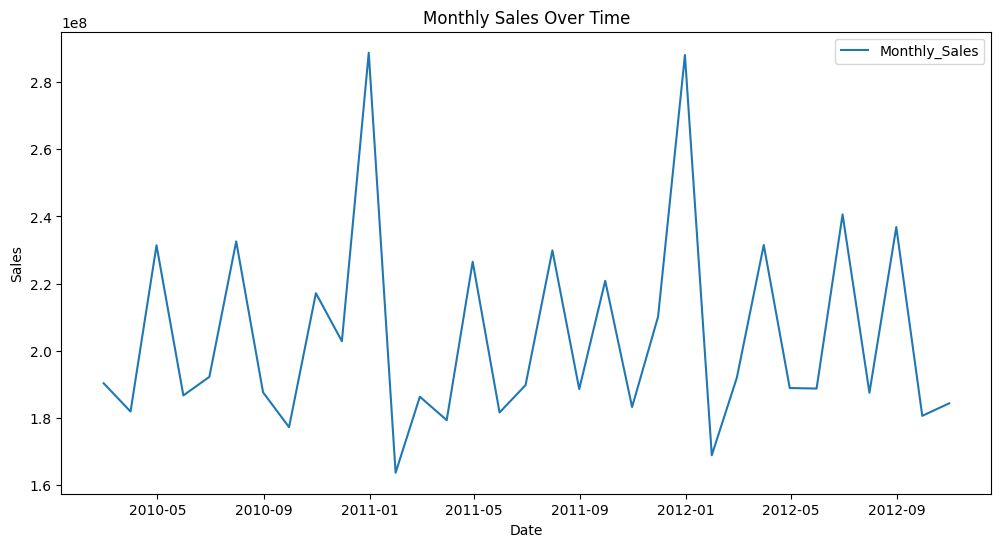

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label="Monthly_Sales")
plt.title("Monthly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

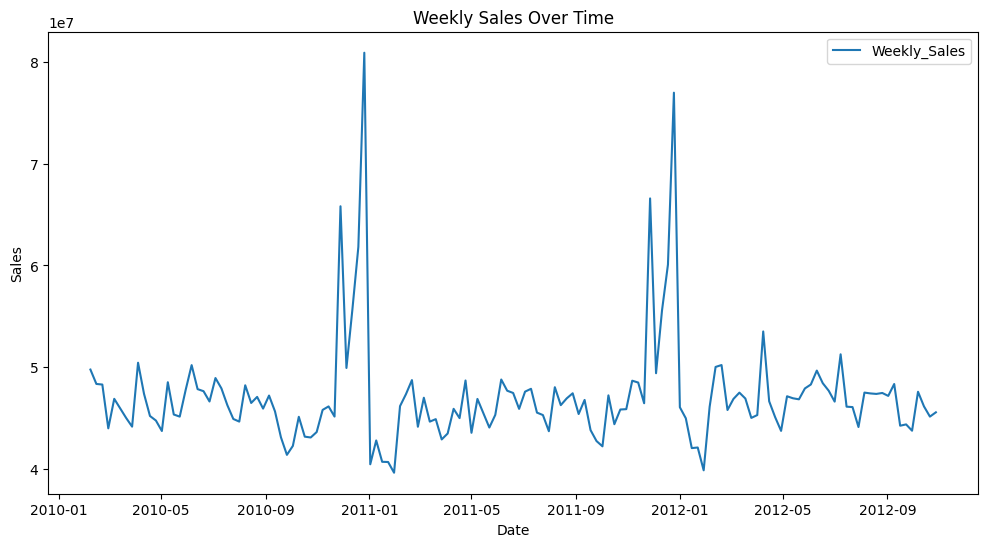

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales, label="Weekly_Sales")
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

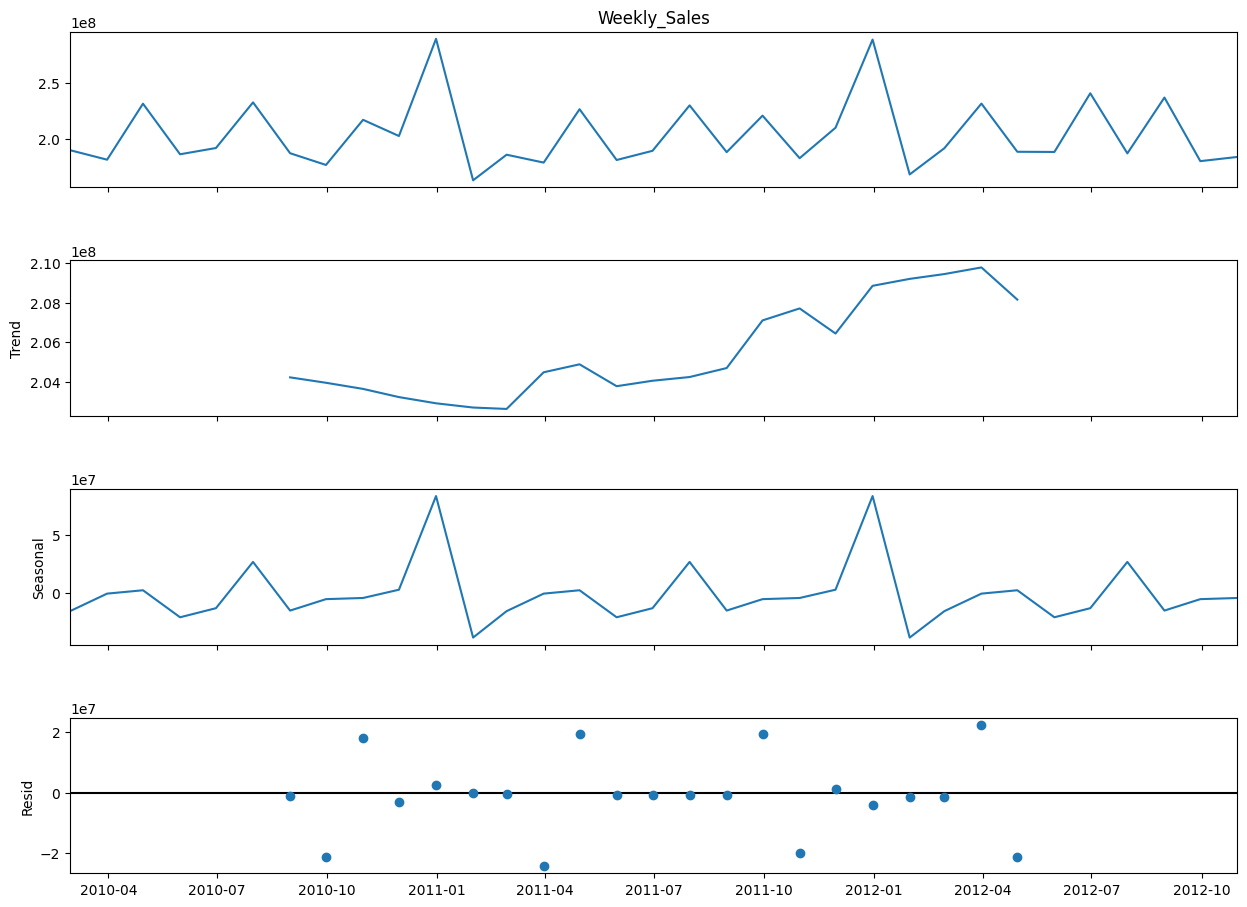

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(monthly_sales, model="additive")
fig = decomp.plot()
fig.set_size_inches(14, 10)
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print("Augmented Dickey-Fuller Test Results")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")

    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    return result[1] < 0.05

is_stationary = check_stationarity(monthly_sales)
print(f"\nTime Series is {'stationary' if is_stationary else 'non-stationary'}")


Augmented Dickey-Fuller Test Results
ADF Statistic: -6.164473786749464
p-value: 7.044293727364691e-08
Critical Values:
	1%: -3.661428725118324
	5%: -2.960525341210433
	10%: -2.6193188033298647

Time Series is stationary


In [13]:
def find_best_arima(self, data, max_p=5, max_d=2, max_q=5):
        """
        Manual grid search for best ARIMA parameters
        """
        best_aic = float('inf')
        best_params = None
        best_model = None

        print("Searching for best ARIMA parameters...")

        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(data, order=(p, d, q))
                        fitted_model = model.fit()

                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_params = (p, d, q)
                            best_model = fitted_model

                    except Exception as e:
                        continue

        print(f"Best ARIMA parameters: {best_params}")
        print(f"Best AIC: {best_aic}")

        self.best_params = best_params
        self.fitted_model = best_model

        return best_params, best_model

In [ ]:
auto_model = auto_sarima(monthly_sales, start_p=0, start_q=0, max_p=5, max_q=5, m=12, seasonal=True, d=None, trace=True, error_action="ignore", suppress_warnings=True, stepwise=True)

In [27]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

def auto_sarima_alternative(data,
                          start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          m=12, seasonal=True,
                          d=None, D=None,
                          trace=True,
                          error_action="ignore",
                          stepwise=True,
                          information_criterion='aic',
                          max_order=10):

    # Convert to pandas Series if needed
    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    # Remove any NaN values
    data = data.dropna()

    if trace:
        print("Performing stepwise search to minimize {}...".format(information_criterion.upper()))
        print(f"Data length: {len(data)}")

    # Auto-determine differencing orders if not provided
    if d is None:
        d = determine_differencing_order(data, trace=trace)

    if D is None and seasonal:
        D = determine_seasonal_differencing_order(data, m, trace=trace)
    elif not seasonal:
        D = 0

    # Define parameter ranges
    p_range = range(start_p, max_p + 1)
    q_range = range(start_q, max_q + 1)

    if seasonal:
        P_range = range(0, min(3, max_p + 1))  # Usually 0-2 for seasonal P
        Q_range = range(0, min(3, max_q + 1))  # Usually 0-2 for seasonal Q
    else:
        P_range = [0]
        Q_range = [0]

    best_ic = float('inf')
    best_model = None
    best_order = None
    best_seasonal_order = None

    # Generate all combinations
    if stepwise:
        # Stepwise search (more efficient)
        param_combinations = stepwise_search(p_range, q_range, P_range, Q_range, d, D, m, max_order)
    else:
        # Full grid search
        param_combinations = list(product(p_range, [d], q_range, P_range, [D], Q_range))
        param_combinations = [(p, d, q, P, D, Q) for p, d, q, P, D, Q in param_combinations
                            if p + q + P + Q <= max_order]

    total_combinations = len(param_combinations)
    if trace:
        print(f"Fitting {total_combinations} models...")

    for i, (p, d_val, q, P, D_val, Q) in enumerate(param_combinations):
        try:
            # Fit SARIMA model
            order = (p, d_val, q)
            seasonal_order = (P, D_val, Q, m) if seasonal else (0, 0, 0, 0)

            model = SARIMAX(data,
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            fitted_model = model.fit(disp=False)

            # Get information criterion
            if information_criterion == 'aic':
                ic_value = fitted_model.aic
            elif information_criterion == 'bic':
                ic_value = fitted_model.bic
            elif information_criterion == 'hqic':
                ic_value = fitted_model.hqic
            else:
                ic_value = fitted_model.aic

            if trace:
                print(f"SARIMA{order}x{seasonal_order} - {information_criterion.upper()}: {ic_value:.3f}")

            # Check if this is the best model so far
            if ic_value < best_ic:
                best_ic = ic_value
                best_model = fitted_model
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            if error_action == "ignore":
                if trace:
                    print(f"SARIMA{(p, d_val, q)}x{(P, D_val, Q, m)} - Failed: {str(e)[:50]}")
                continue
            else:
                raise e

    if best_model is None:
        raise ValueError("No suitable model found. Try expanding parameter ranges.")

    if trace:
        print(f"\nBest model: SARIMA{best_order}x{best_seasonal_order}")
        print(f"Best {information_criterion.upper()}: {best_ic:.3f}")

    return best_model, best_order, best_seasonal_order

def determine_differencing_order(data, max_d=2, trace=False):
    """Determine optimal differencing order using ADF test"""
    for d in range(max_d + 1):
        if d == 0:
            diff_data = data
        else:
            diff_data = data.diff(periods=d).dropna()

        # Perform ADF test
        adf_result = adfuller(diff_data)
        p_value = adf_result[1]

        if trace:
            print(f"Testing d={d}: ADF p-value = {p_value:.4f}")

        # If p-value < 0.05, series is stationary
        if p_value < 0.05:
            if trace:
                print(f"Series is stationary with d={d}")
            return d

    if trace:
        print(f"Using maximum d={max_d}")
    return max_d

def determine_seasonal_differencing_order(data, m, max_D=1, trace=False):
    """Determine seasonal differencing order"""
    for D in range(max_D + 1):
        if D == 0:
            diff_data = data
        else:
            diff_data = data.diff(periods=m*D).dropna()

        if len(diff_data) < 2*m:  # Need enough data
            continue

        # Simple test for seasonal stationarity
        # You could implement a more sophisticated test here
        try:
            adf_result = adfuller(diff_data)
            p_value = adf_result[1]

            if trace:
                print(f"Testing seasonal D={D}: ADF p-value = {p_value:.4f}")

            if p_value < 0.05:
                if trace:
                    print(f"Seasonally stationary with D={D}")
                return D
        except:
            continue

    return 0

def stepwise_search(p_range, q_range, P_range, Q_range, d, D, m, max_order):
    """
    Implement a stepwise search similar to auto_arima
    Start with simple models and expand
    """
    # Start with simple models
    initial_models = [
        (0, d, 0, 0, D, 0),  # (0,d,0)(0,D,0)
        (1, d, 0, 0, D, 0),  # (1,d,0)(0,D,0)
        (0, d, 1, 0, D, 0),  # (0,d,1)(0,D,0)
        (1, d, 1, 0, D, 0),  # (1,d,1)(0,D,0)
    ]

    # Add seasonal variants if applicable
    if max(P_range) > 0 or max(Q_range) > 0:
        seasonal_models = [
            (0, d, 0, 1, D, 0),  # (0,d,0)(1,D,0)
            (0, d, 0, 0, D, 1),  # (0,d,0)(0,D,1)
            (1, d, 0, 1, D, 0),  # (1,d,0)(1,D,0)
            (0, d, 1, 0, D, 1),  # (0,d,1)(0,D,1)
        ]
        initial_models.extend(seasonal_models)

    # Generate more combinations around promising areas
    all_combinations = []
    for p in p_range:
        for q in q_range:
            for P in P_range:
                for Q in Q_range:
                    if p + q + P + Q <= max_order:
                        all_combinations.append((p, d, q, P, D, Q))

    # Combine initial models with full search, removing duplicates
    combined = list(set(initial_models + all_combinations))

    return combined


best_model, best_order, best_seasonal_order = auto_sarima_alternative(
        monthly_sales,
        start_p=0, start_q=0,
        max_p=5, max_q=5,
        m=12, seasonal=True,
        d=None,
        trace=True,
        error_action="ignore",
        stepwise=True
    )

Performing stepwise search to minimize AIC...
Data length: 33
Testing d=0: ADF p-value = 0.0000
Series is stationary with d=0
Testing seasonal D=0: ADF p-value = 0.0000
Seasonally stationary with D=0
Fitting 291 models...
SARIMA(4, 0, 1)x(0, 0, 0, 12) - AIC: 1099.170
SARIMA(4, 0, 1)x(2, 0, 2, 12) - AIC: 202.911
SARIMA(1, 0, 4)x(1, 0, 0, 12) - AIC: 748.570
SARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC: 747.850
SARIMA(5, 0, 0)x(2, 0, 1, 12) - AIC: 163.660
SARIMA(0, 0, 3)x(1, 0, 2, 12) - AIC: 214.650
SARIMA(3, 0, 3)x(1, 0, 0, 12) - AIC: 674.913
SARIMA(2, 0, 5)x(2, 0, 1, 12) - AIC: 278.142
SARIMA(2, 0, 2)x(2, 0, 1, 12) - AIC: 273.795
SARIMA(1, 0, 3)x(2, 0, 0, 12) - AIC: 306.821
SARIMA(1, 0, 0)x(2, 0, 0, 12) - AIC: 309.461
SARIMA(2, 0, 0)x(2, 0, 1, 12) - AIC: 272.947
SARIMA(5, 0, 2)x(2, 0, 1, 12) - AIC: 167.642
SARIMA(0, 0, 1)x(2, 0, 0, 12) - AIC: 369.378
SARIMA(0, 0, 2)x(2, 0, 1, 12) - AIC: 373.439
SARIMA(3, 0, 4)x(0, 0, 2, 12) - AIC: 164.612
SARIMA(5, 0, 3)x(0, 0, 0, 12) - AIC: 1062.065
SARIMA(0, 0

In [28]:
from statsmodels.tsa.arima.model import ARIMA

In [29]:
order = (1, 0, 5)
seasonal_order = (0, 0, 2, 12)
model = ARIMA(monthly_sales, order=order, seasonal_order=seasonal_order)
results = model.fit()

In [31]:
per = 12
forecast = results.get_forecast(steps=per)
mean_forecast = forecast.predicted_mean

In [32]:
conf_int_95 = forecast.conf_int(alpha=0.05)
conf_int_80 = forecast.conf_int(alpha=0.20)
conf_int_70 = forecast.conf_int(alpha=0.30)

In [ ]:
plt.figure(figsize(15, 7))

